In [1]:
# all necessary imports for project
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [2]:
'''LOADING DATA FROM FILES'''

import pandas as pd
import os

# Load label file
label_df = pd.read_excel('../Data/wax/data labels anna - simple.xlsx')
# clean up column names
label_df.columns = ['code', 'month', 'ID', 'optimality', 'abnormal', 'AIMS']
print(label_df.head())

# Cleanup data, remove rows where AIMS score is 999
AIMS_cleaned_label_df = label_df[label_df.AIMS != 999]

   code  month   ID  optimality  abnormal  AIMS
0  1023      0  180           9       1.0     1
1  1023      1  195          14       1.0   999
2  1023      2  197          26       1.0     1
3  1023      3  206          11       1.0     2
4  1023      4  208          13       1.0     1


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import sys

def load_sensor_data(trial_folder, sensor):
    df = pd.read_csv(trial_folder + "/" + sensor + ".csv")
    df = df[(df.T != 0).any()]
    return df


def combine_dfs(dfs):
    return pd.concat(dfs, axis=1)

def process_df(df, min_rows):
    '''# Drop rows where all entries are zero
    df = df[(df.T != 0).any()]
    # Truncate dataframe to min_rows
    df = df[:min_rows]
    return df'''

    # Drop rows where all entries are zero
    df = df.loc[(df != 0).any(axis=1)]
    # Truncate dataframe to min_rows
    df = df[:min_rows]
    return df

def rename_columns(df):
    df.columns = ['Time', 'AccXRA', 'AccYRA', 'AccZRA', 'GyrXRA', 'GyrYRA', 'GyrZRA', 'MagXRA', 'MagYRA', 'MagZRA',
                  'AccXLA', 'AccYLA', 'AccZLA', 'GyrXLA', 'GyrYLA', 'GyrZLA', 'MagXLA', 'MagYLA', 'MagZLA',
                  'AccXRW', 'AccYRW', 'AccZRW', 'GyrXRW', 'GyrYRW', 'GyrZRW', 'MagXRW', 'MagYRW', 'MagZRW',
                  'AccXLW', 'AccYLW', 'AccZLW', 'GyrXLW', 'GyrYLW', 'GyrZLW', 'MagXLW', 'MagYLW', 'MagZLW']
    return df

def renames_columns_sum(df):
    df.columns = ['Time', 'AccXRA', 'AccYRA', 'AccZRA', 'AccSumRA', 'GyrXRA', 'GyrYRA', 'GyrZRA', 'MagXRA', 'MagYRA', 'MagZRA',
                  'AccXLA', 'AccYLA', 'AccZLA', 'AccSumLA', 'GyrXLA', 'GyrYLA', 'GyrZLA', 'MagXLA', 'MagYLA', 'MagZLA',
                  'AccXRW', 'AccYRW', 'AccZRW', 'AccSumRW', 'GyrXRW', 'GyrYRW', 'GyrZRW', 'MagXRW', 'MagYRW', 'MagZRW',
                  'AccXLW', 'AccYLW', 'AccZLW', 'AccSumLW', 'GyrXLW', 'GyrYLW', 'GyrZLW', 'MagXLW', 'MagYLW', 'MagZLW']
    return df

def calculate_acceleration_sums(df):
    df['AccSumRA'] = np.sqrt(df['AccXRA']**2 + df['AccYRA']**2 + df['AccZRA']**2)
    df['AccSumLA'] = np.sqrt(df['AccXLA']**2 + df['AccYLA']**2 + df['AccZLA']**2)
    df['AccSumRW'] = np.sqrt(df['AccXRW']**2 + df['AccYRW']**2 + df['AccZRW']**2)
    df['AccSumLW'] = np.sqrt(df['AccXLW']**2 + df['AccYLW']**2 + df['AccZLW']**2)
    return df

def calculate_rolling_mean(df, window_size):
    df['AccSumSumR_Rolling10000'] = df['AccSumSumR'].rolling(window_size).mean()
    return df

def trim_df(df, start_index, end_index):
    return df.iloc[start_index:end_index-10000]

def drop_columns(df, columns):
    df.drop(columns=columns, inplace=True)
    return df

def calculate_peak_indices(first_half, second_half, column_name):
    
    start_peak_index = first_half[column_name].idxmax() + 10000
    end_peak_index = second_half[column_name].idxmax() - 10000

    return start_peak_index, end_peak_index

def get_initial_combined_df(trial_folder):
    ra_df = load_sensor_data(trial_folder, "RA")
    la_df = load_sensor_data(trial_folder, "LA")
    rw_df = load_sensor_data(trial_folder, "RW")
    lw_df = load_sensor_data(trial_folder, "LW")

    # Drop rows where all entries are zero
    ra_df = ra_df.loc[(ra_df != 0).any(axis=1)]
    la_df = la_df.loc[(la_df != 0).any(axis=1)]
    rw_df = rw_df.loc[(rw_df != 0).any(axis=1)]
    lw_df = lw_df.loc[(lw_df != 0).any(axis=1)]

    ra_df, la_df, rw_df, lw_df = consistent_length(ra_df, la_df, rw_df, lw_df)

    # Remove first column from la, rw, lw dfs using indexing
    la_df = la_df.iloc[:, 1:]
    rw_df = rw_df.iloc[:, 1:]
    lw_df = lw_df.iloc[:, 1:]

    combined_df = combine_dfs([ra_df, la_df, rw_df, lw_df])

    return combined_df, ra_df, la_df, rw_df, lw_df

def consistent_length(ra_df, la_df, rw_df, lw_df):
    # truncate the dataframes to the same length
    min_rows = min(ra_df.shape[0], la_df.shape[0], rw_df.shape[0], lw_df.shape[0])
    ra_df = ra_df[:min_rows]
    la_df = la_df[:min_rows]
    rw_df = rw_df[:min_rows]
    lw_df = lw_df[:min_rows]
    return ra_df, la_df, rw_df, lw_df

def column_organisation(combined_df):
    
    num_cols = combined_df.shape[1]

    # If number of columns is 37, acc, gyr and mag data is present.
    # If number of columns is 13, only acc data is present.
    if num_cols == 37:
        combined_df = rename_columns(combined_df)
        combined_df = calculate_acceleration_sums(combined_df)
        allSensors = True
    else:
        combined_df.columns = ['Time', 'AccXRA', 'AccYRA', 'AccZRA', 'AccXLA', 'AccYLA', 'AccZLA', 'AccXRW', 'AccYRW', 'AccZRW', 'AccXLW', 'AccYLW', 'AccZLW']
        combined_df = calculate_acceleration_sums(combined_df)
        allSensors = False
    return combined_df, allSensors


def process_trial(index, row, label_df):

    if index%10 == 0:
        print("processing instance", index)

    trial_id = row["ID"]
    infant_id = row["code"]

    if trial_id < 10:
        addedZero = '00'
    elif row['ID'] < 100:
        addedZero = '0'
    else:
        addedZero = ''

    trial_folder = '../Data/wax/p' + addedZero + str(trial_id)

    combined_df, ra_df, la_df, rw_df, lw_df = get_initial_combined_df(trial_folder)
    combined_df, allSensors = column_organisation(combined_df)

    # Split df in half
    first_half = combined_df.iloc[0:combined_df.shape[0]//2]
    second_half = combined_df.iloc[combined_df.shape[0]//2:combined_df.shape[0]]
   
    ra_start_peak_index, ra_end_peak_index = calculate_peak_indices(first_half, second_half, 'AccSumRA')
    la_start_peak_index, la_end_peak_index = calculate_peak_indices(first_half, second_half, 'AccSumLA')
    rw_start_peak_index, rw_end_peak_index = calculate_peak_indices(first_half, second_half, 'AccSumRW')
    lw_start_peak_index, lw_end_peak_index = calculate_peak_indices(first_half, second_half, 'AccSumLW')

    starts = [ra_start_peak_index, la_start_peak_index, rw_start_peak_index, lw_start_peak_index]
    ends = [ra_end_peak_index, la_end_peak_index, rw_end_peak_index, lw_end_peak_index]

    max_end = max(ends)
    max_index = ends.index(max_end)
    max_start = starts[max_index]
    difference = max_end - max_start

    ra_df_trimmed = ra_df.iloc[ra_start_peak_index:ra_start_peak_index+difference].reset_index(drop=True)
    la_df_trimmed = la_df.iloc[la_start_peak_index:la_start_peak_index+difference].reset_index(drop=True)
    rw_df_trimmed = rw_df.iloc[rw_start_peak_index:rw_start_peak_index+difference].reset_index(drop=True)
    lw_df_trimmed = lw_df.iloc[lw_start_peak_index:lw_start_peak_index+difference].reset_index(drop=True)

    ra_df_trimmed, la_df_trimmed, rw_df_trimmed, lw_df_trimmed = consistent_length(ra_df_trimmed, la_df_trimmed, rw_df_trimmed, lw_df_trimmed)

    trimmed_df = combine_dfs([ra_df_trimmed, la_df_trimmed, rw_df_trimmed, lw_df_trimmed])
    trimmed_df, allSensors = column_organisation(trimmed_df)
   

    # Plot trimmed_df for every 10 instances (sanity check)
    if index % 50 == 0:
        trimmed_df.plot(x='Time', y=['AccSumRA', 'AccSumLA', 'AccSumRW', 'AccSumLW'], title='Sum of Accelerometer Values for each limb (Data trimmed)')    


    # If trimmed_df is empty, raise an exception. Prevents empty dataframes from being added to the list
    if trimmed_df.empty:
        raise Exception("Empty dataframe")

    # Check for NaN values in trimmed_df
    if trimmed_df.isnull().values.any():
        raise Exception("NaN values present in trimmed_df")

    return trimmed_df, row['month'], row['code'], row['abnormal'], row['AIMS'], row['optimality'], allSensors

processing instance 0
File not found for instance 0
File not found for instance 2
File not found for instance 3
File not found for instance 4
File not found for instance 5
File not found for instance 6
processing instance 10
File not found for instance 11
Error processing instance 14
Error Empty dataframe
Error on line 11
Error on line 170
File not found for instance 17
File not found for instance 18
processing instance 20
File not found for instance 22
File not found for instance 23
File not found for instance 29
processing instance 30
File not found for instance 39
processing instance 40
processing instance 50
Error processing instance 59
Error NaN values present in trimmed_df
Error on line 11
Error on line 174
processing instance 60
processing instance 70
processing instance 80
File not found for instance 82
processing instance 90
File not found for instance 94
processing instance 100
processing instance 110
File not found for instance 116
File not found for instance 117
processing 

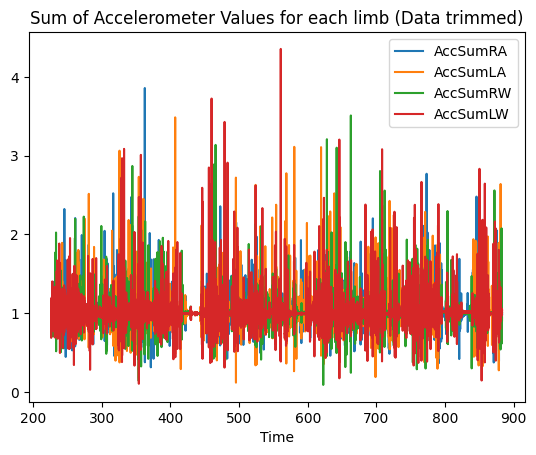

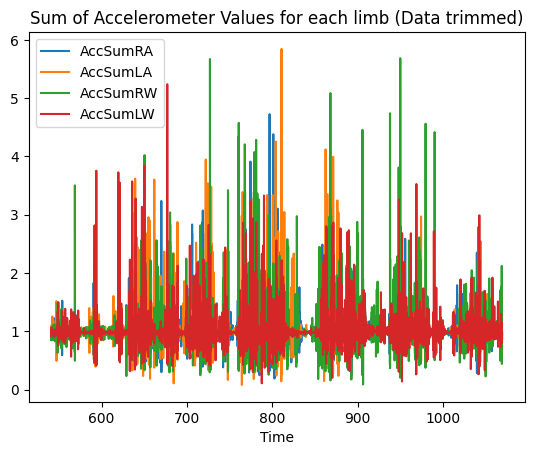

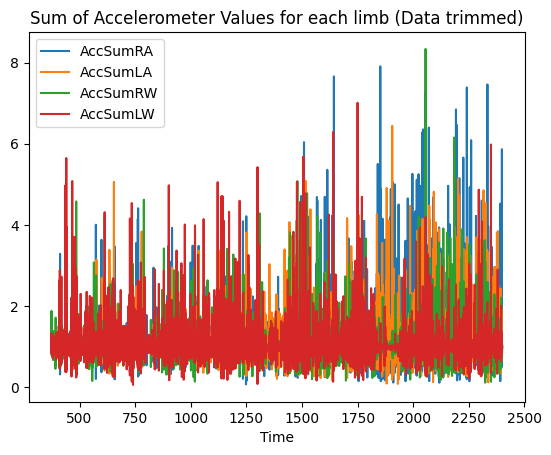

In [4]:
# Create 1 big dataframe with all the data
'''allData = {'Measurements': [], 'Month': [], 'Code': [], 'Abnormal': [], 'AIMS': [], 'Optimality': []}'''
accelData = {'Measurements': [], 'Month': [], 'Code': [], 'Abnormal': [], 'AIMS': [], 'Optimality': []}

# Keep track of rows that raise exceptions
error_rows = []

def save_trials():
    for index, row in label_df.iterrows():
        try:
            measurements, month, code, abnormal, aims, optimality, allSensors = process_trial(index, row, label_df)

            if allSensors:
                '''

                # Add all data collected to allData
                allData['Measurements'].append(measurements)
                allData['Month'].append(month)
                allData['Code'].append(code)
                allData['Abnormal'].append(abnormal)
                allData['AIMS'].append(aims)
                allData['Optimality'].append(optimality)
                '''

                # Add only accelerometer data to accelData
                just_accel = measurements.copy()
                
                cols = ['MagXRA', 'MagYRA', 'MagZRA', 'MagXLA', 'MagYLA', 'MagZLA', 'MagXRW', 'MagYRW', 'MagZRW', 'MagXLW', 'MagYLW', 'MagZLW',
                'GyrXRA', 'GyrYRA', 'GyrZRA', 'GyrXLA', 'GyrYLA', 'GyrZLA', 'GyrXRW', 'GyrYRW', 'GyrZRW', 'GyrXLW', 'GyrYLW', 'GyrZLW']

                just_accel.drop(columns=cols, inplace=True)
    

                accelData['Measurements'].append(just_accel)
                accelData['Month'].append(month)
                accelData['Code'].append(code)
                accelData['Abnormal'].append(abnormal)
                accelData['AIMS'].append(aims)
                accelData['Optimality'].append(optimality)

            else:
                
                # if only accelerometer data was collected, just add it to accelData
                accelData['Measurements'].append(measurements)
                accelData['Month'].append(month)
                accelData['Code'].append(code)
                accelData['Abnormal'].append(abnormal)
                accelData['AIMS'].append(aims)
                accelData['Optimality'].append(optimality)

        except FileNotFoundError:
            print("File not found for instance", index)
            error_rows.append((index, row))

        except Exception as e:
            print("Error processing instance", index)
            print("Error", e) 
            # print line number of error
            print("Error on line {}".format(sys.exc_info()[-1].tb_lineno))
            # print line further back in the traceback
            print("Error on line {}".format(sys.exc_info()[-1].tb_next.tb_lineno))
            error_rows.append((index, row)) 

save_trials()



In [5]:
# save accelData to a pickle should kernel have to restart
import pickle
with open('Pickles/accelData.pickle', 'wb') as handle:
    pickle.dump(accelData, handle)

# Save to original file in case any issues happen when resaving
with open('Pickles/accelDataOriginal.pickle', 'wb') as handle:
    pickle.dump(accelData, handle)

In [13]:
# open accelData pickle
import pickle
with open('Pickles/accelData.pickle', 'rb') as handle:
    accelData = pickle.load(handle)

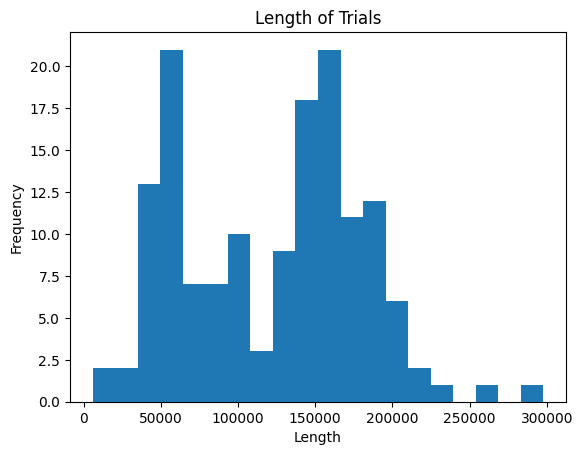

In [14]:
# PLot histogram of length of trials
lengths = [len(accelData['Measurements'][i]) for i in range(len(accelData['Measurements']))]
plt.hist(lengths, bins=20)
plt.title("Length of Trials")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

In [15]:
og_accelData = accelData.copy()

In [41]:
# Plot distribution of labels: AIMS, abnormality and optimality

# AIMS
plt.hist(accelData[accelData['AIMS']<100]['AIMS'], bins=20)
plt.title("AIMS Distribution")
plt.xlabel("AIMS")
plt.ylabel("Frequency")
plt.show()

# Abnormality
plt.hist(accelData['Abnormal'], bins=20)
plt.title("Abnormality Distribution")
plt.xlabel("Abnormal")
plt.ylabel("Frequency")
plt.show()

# Optimality
plt.hist(accelData[accelData['Optimality'] < 100]['Optimality'], bins=20)
plt.title("Optimality Distribution")
plt.xlabel("Optimality")
plt.ylabel("Frequency")
plt.show()


TypeError: '<' not supported between instances of 'list' and 'int'

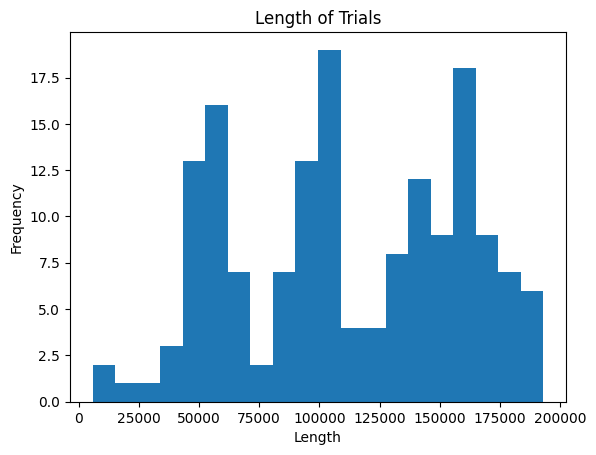

In [16]:
K = 14

# Split some of the longer trials in half
numRowsAccel = [df.shape[0] for df in accelData['Measurements']]
sortedIndices = np.argsort(numRowsAccel)

# Get the indices of the top k dataframes
topKIndices = sortedIndices[-K:]

# Get the top k dataframes
topKDataframes = [accelData['Measurements'][i] for i in topKIndices]

# Get the top k corresponding months, IDs, labels
topKMonths = [accelData['Month'][i] for i in topKIndices]
topKCodes = [accelData['Code'][i] for i in topKIndices]
topKAbnormal = [accelData['Abnormal'][i] for i in topKIndices]
topKAIMS = [accelData['AIMS'][i] for i in topKIndices]
topKOptimality = [accelData['Optimality'][i] for i in topKIndices]

# Remove the dataframes from accelData
for i in sorted(topKIndices, reverse=True):
    del accelData['Measurements'][i]
    del accelData['Month'][i]
    del accelData['Code'][i]
    del accelData['Abnormal'][i]
    del accelData['AIMS'][i]
    del accelData['Optimality'][i]

# Split the top k dataframes into two and reinsert into structure
for i in range(len(topKDataframes)):
    df = topKDataframes[i]
    month = topKMonths[i]
    code = topKCodes[i]
    abnormal = topKAbnormal[i]
    aims = topKAIMS[i]
    optimality = topKOptimality[i]
    
    first_half = df.iloc[0:df.shape[0]//2]
    second_half = df.iloc[df.shape[0]//2:df.shape[0]]
    
    # Append the first and second halves to accelData
    accelData['Measurements'].append(first_half)
    accelData['Measurements'].append(second_half)
    
    # Append the corresponding values for month, code, abnormal, aims, and optimality
    accelData['Month'].extend([month, month])
    accelData['Code'].extend([code, code])
    accelData['Abnormal'].extend([abnormal, abnormal])
    accelData['AIMS'].extend([aims, aims])
    accelData['Optimality'].extend([optimality, optimality])

# PLot histogram of length of trials
lengths = [len(accelData['Measurements'][i]) for i in range(len(accelData['Measurements']))]
plt.hist(lengths, bins=20)
plt.title("Length of Trials")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()
    
# Memory management
del numRowsAccel
del topKIndices
del sortedIndices
del topKDataframes
del topKMonths
del topKCodes
del topKAbnormal
del topKAIMS
del topKOptimality
del first_half
del second_half
del df
del month
del code
del abnormal
del aims
del optimality

In [17]:
# Remove time column from accelData Measurements
accelData['Measurements with Time'] = accelData['Measurements']

for i in range(len(accelData['Measurements'])):
    accelData['Measurements'][i] = accelData['Measurements'][i].iloc[:, 1:]



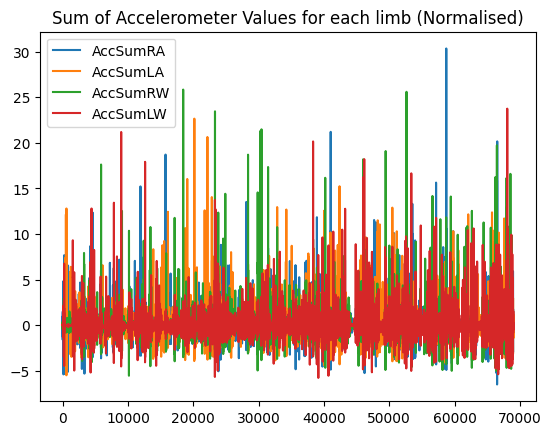

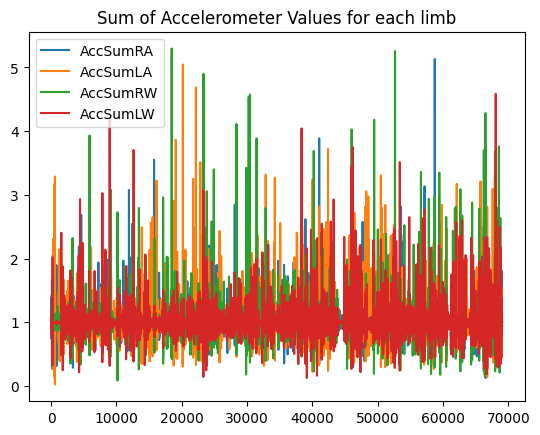

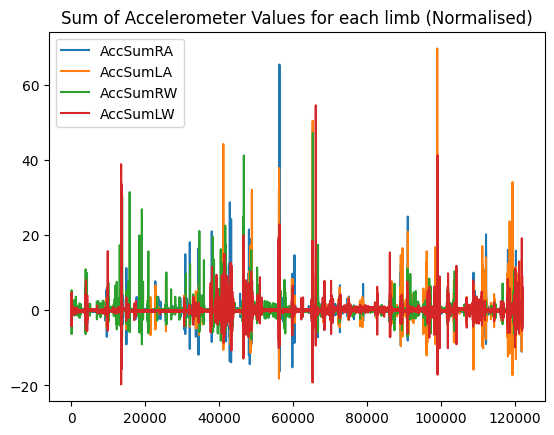

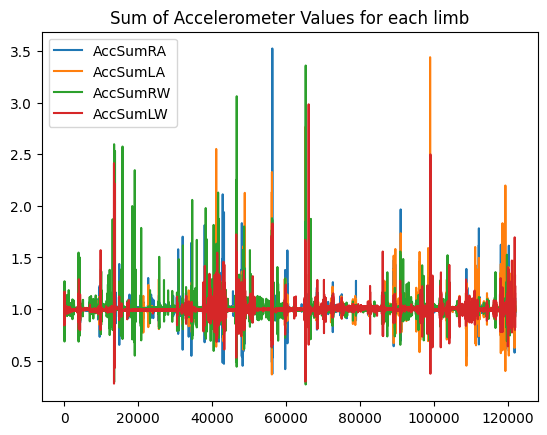

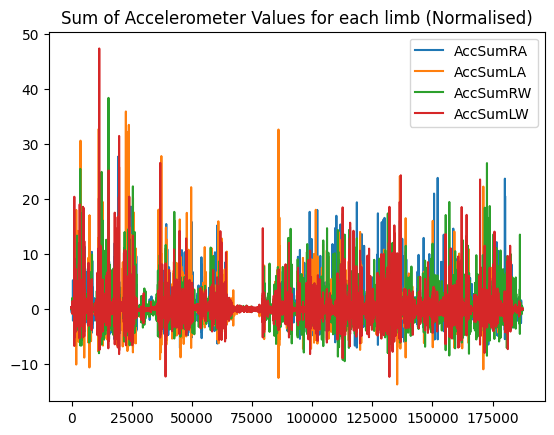

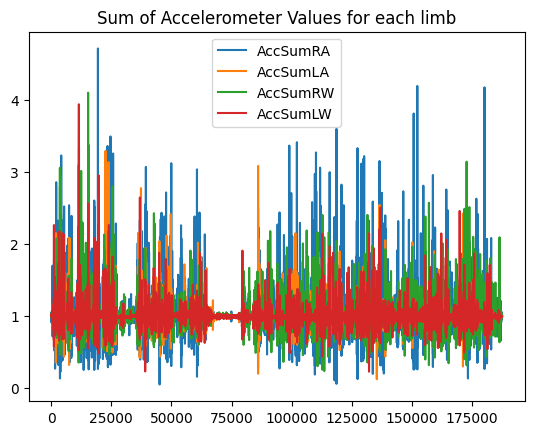

In [13]:
# Create another key-value pair in the accelData dictionary with the measurement data normalised
accelData['Normalised'] = []
for i in range(len(accelData['Measurements'])):
    df = accelData['Measurements'][i]
    normalised = (df - df.mean()) / df.std()
    accelData['Normalised'].append(normalised)

# Memory management
del normalised
del df

In [18]:
# Smooth the normalised data using a moving average (mean)
accelData['Smoothed (mean)'] = []
# Smooth the data using a moving average (median)
accelData['Smoothed (median)'] = []

for i in range(len(accelData['Measurements'])):
    df = accelData['Measurements'][i]

    # Mean smoothing
    smoothed_mean = df.rolling(window=10).mean()
    smoothed_mean = smoothed_mean.fillna(df)
    # downsampling
    smoothed_mean = smoothed_mean.groupby(smoothed_mean.index // 10).mean()
    accelData['Smoothed (mean)'].append(smoothed_mean)

    # Median smoothing
    smoothed_med = df.rolling(window=10).median()
    smoothed_med = smoothed_med.fillna(df)
    # downsampling
    smoothed_med = smoothed_med.groupby(smoothed_med.index // 10).median()
    accelData['Smoothed (median)'].append(smoothed_med)


In [19]:
# Normalise the smoothed data
accelData['Smoothed (mean) then Normalised'] = []
accelData['Smoothed (median) then Normalised'] = []

for i in range(len(accelData['Smoothed (mean)'])):
    df = accelData['Smoothed (mean)'][i]
    normalised = (df - df.mean()) / df.std()
    accelData['Smoothed (mean) then Normalised'].append(normalised)
    df = accelData['Smoothed (median)'][i]
    normalised = (df - df.mean()) / df.std()
    accelData['Smoothed (median) then Normalised'].append(normalised)

In [20]:
# Add padding to smoothed (mean) then normalised and smoothed(median) then normalised dataframes

# Get the maximum number of rows in the dataframes
maxRows = max([df.shape[0] for df in accelData['Smoothed (mean) then Normalised']])
print("Max number of rows in the dataframes:", maxRows)
# Get the number of columns in the dataframes
numCols = accelData['Smoothed (mean) then Normalised'][0].shape[1]

# Add padding to the dataframes in accelData['Smoothed (mean) then Normalised']
for i in range(len(accelData['Smoothed (mean) then Normalised'])):
    df = accelData['Smoothed (mean) then Normalised'][i]
    padding = pd.DataFrame(np.zeros((maxRows - df.shape[0], numCols)), columns=df.columns)
    df = df.append(padding, ignore_index=True)
    accelData['Smoothed (mean) then Normalised'][i] = df

# Add padding to the dataframes in accelData['Smoothed (median) then Normalised']
for i in range(len(accelData['Smoothed (median) then Normalised'])):
    df = accelData['Smoothed (median) then Normalised'][i]
    padding = pd.DataFrame(np.zeros((maxRows - df.shape[0], numCols)), columns=df.columns)
    df = df.append(padding, ignore_index=True)
    accelData['Smoothed (median) then Normalised'][i] = df

Max number of rows in the dataframes: 19301


In [ ]:
# save smoothed (median) then normalised and smoothed (mean) then normalised dataframes to pickle

with open('Pickles/X_smoothed_mean_norm.pickle', 'wb') as handle:
    pickle.dump(accelData['Smoothed (mean) then Normalised'], handle)

with open('Pickles/X_smoothed_median_norm.pickle', 'wb') as handle:
    pickle.dump(accelData['Smoothed (median) then Normalised'], handle)

In [ ]:
# Add month values to smoothed_mean_norm and smoothed_median_norm dataframes 
X_sm_mean_norm_month = accelData['Smoothed (mean) then Normalised'].copy()
X_sm_median_norm_month = accelData['Smoothed (median) then Normalised'].copy()


for i in range(len(X_sm_mean_norm_month)):
    df = X_sm_mean_norm_month[i]
    df['Month'] = accelData['Month'][i]
    df = X_sm_median_norm_month[i]
    df['Month'] = accelData['Month'][i]

# save smoothed (median) then normalised and smoothed (mean) then normalised dataframes to pickle

with open('Pickles/X_smoothed_mean_norm_month.pickle', 'wb') as handle:
    pickle.dump(X_sm_mean_norm_month, handle)

with open('Pickles/X_smoothed_median_norm_month.pickle', 'wb') as handle:
    pickle.dump(X_sm_median_norm_month, handle)

In [22]:
%pip install fastdtw

Note: you may need to restart the kernel to use updated packages.Collecting fastdtw
  Created wheel for fastdtw: filename=fastdtw-0.3.4-py3-none-any.whl size=3609 sha256=e93d209877bbfa3d99e2f4499f1a50b227b6135bcca3278498174cf5f1be51a7
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\a2\da\8c\2d1b9b233595056f05e59156bb555f7277b88beb385605de16
Successfully built fastdtw



You should consider upgrading via the 'c:\Users\User\AppData\Local\Programs\Python\Python37\python.exe -m pip install --upgrade pip' command.


In [28]:
# Augmenting Time Series Sensor Data
# To enhance our dataset and improve model performance on time series sensor data,
# we implement targeted data augmentation techniques. These methods are designed
# to artificially expand our dataset with realistic variations, ensuring that our
# model can generalize well to unseen data by being exposed to a broader range of
# scenarios during training.

# 1. Time Warping:
# - Apply slight distortions along the time axis to simulate variations in the
#   speed at which events occur. This helps the model recognize patterns
#   irrespective of temporal compression or expansion.

# Implementation of time warping:
# - We use the Dynamic Time Warping (DTW) algorithm to perform time warping on
#   our time series sensor data. This algorithm measures the similarity between
#   two sequences that may vary in time or speed, and finds the optimal
#   alignment between them.

# Import necessary libraries
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

def time_warping(data, time_stretch_factor):
    data_warped_list = []
    for df in data:
        # print the progress
        print("Processing dataframe", data.index(df))
        # Initialize an empty DataFrame to hold the warped series
        df_warped = pd.DataFrame(index=np.arange(0, len(df), time_stretch_factor))
        for col in df.columns:
            # print the progress
            print("Processing column", df.columns.get_loc(col))
            series = df[col]
            length = len(series)
            time_axis = np.arange(length)
            time_axis_stretched = np.arange(0, length, time_stretch_factor)
            series_warped = np.empty(len(time_axis_stretched))
            for i, time_point in enumerate(time_axis_stretched):
                # Ensure time_point is an integer for .iloc
                time_point_int = int(time_point)
                if i == 0 or i == len(time_axis_stretched)-1:
                    # For the first and last points, no interpolation is needed
                    series_warped[i] = series.iloc[time_point_int] if time_point_int < length else series.iloc[-1]
                else:
                    # Find the two closest time points in the original axis for interpolation
                    low = max(filter(lambda x: x <= time_point, time_axis))
                    high = min(filter(lambda x: x >= time_point, time_axis))
                    low_int = int(low)  # Ensure low is integer for .iloc
                    high_int = int(high)  # Ensure high is integer for .iloc
                    # Linear interpolation for this time point
                    series_warped[i] = np.interp(time_point, [low, high], [series.iloc[low_int], series.iloc[high_int]])
            # Assign the interpolated series to the corresponding column in the warped DataFrame
            df_warped[col] = series_warped
        # Append the warped DataFrame to the list
        data_warped_list.append(df_warped)
    return data_warped_list

import numpy as np
import pandas as pd
from joblib import Parallel, delayed

def interpolate_series(series, time_axis, time_axis_stretched):
    # Vectorized interpolation (assuming series is a pandas Series or a NumPy array)
    # This function should be adapted based on your specific requirements for interpolation
    return np.interp(time_axis_stretched, time_axis, series)

def process_column(series, time_stretch_factor):
    length = len(series)
    time_axis = np.arange(length)
    time_axis_stretched = np.arange(0, length, time_stretch_factor)
    return interpolate_series(series, time_axis, time_axis_stretched)

def time_warping_parallel(df, time_stretch_factor):
    results = Parallel(n_jobs=-1)(delayed(process_column)(df[col], time_stretch_factor) for col in df.columns)
    return pd.DataFrame(results).T  # Transpose to align with original DataFrame structure

def time_warping_batch(data, time_stretch_factor, batch_size=10):
    data_warped_list = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        batch_warped = [time_warping_parallel(df, time_stretch_factor) for df in batch]
        data_warped_list.extend(batch_warped)
    return data_warped_list

# Example usage
time_stretch_factor = 1.5
X_time_warped = time_warping_batch(accelData['Measurements'], time_stretch_factor)


# Combine time warped data with original data
X_combined = accelData['Measurements'] + X_time_warped

# Check size of combined dataset
print("Size of combined dataset:", len(X_combined))

# Mean smooth and normalise the combined dataset
X_combined_smoothed_mean_norm = []
for i in range(len(X_combined)):
    df = X_combined[i]
    smoothed_mean = df.rolling(window=10).mean()
    smoothed_mean = smoothed_mean.fillna(df)
    # downsampling
    smoothed_mean = smoothed_mean.groupby(smoothed_mean.index // 10).mean()
    normalised = (smoothed_mean - smoothed_mean.mean()) / smoothed_mean.std()
    X_combined_smoothed_mean_norm.append(normalised)

# Pad the combined dataset
maxRows = max([df.shape[0] for df in X_combined_smoothed_mean_norm])
numCols = X_combined_smoothed_mean_norm[0].shape[1]
for i in range(len(X_combined_smoothed_mean_norm)):
    df = X_combined_smoothed_mean_norm[i]
    padding = pd.DataFrame(np.zeros((maxRows - df.shape[0], numCols)), columns=df.columns)
    df = df.append(padding, ignore_index=True)
    X_combined_smoothed_mean_norm[i] = df

# save time warped data to pickle
with open('Pickles/X_time_warped.pickle', 'wb') as handle:
    pickle.dump(X_combined_smoothed_mean_norm, handle)

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


In [2]:


# 2. Window Slicing:
# - Generate new samples by slicing the time series into overlapping windows.
#   Adjust the size and overlap of the windows to control the diversity and
#   quantity of generated samples.

# Implementation of window slicing:
# - We use a sliding window approach to slice the time series sensor data into
#   overlapping windows. This technique allows us to create new samples with
#   varying start and end points, and can be used to generate a large number of
#   augmented samples from a single time series.

# Create a function to perform window slicing on the data
def window_slicing(data, window_size, overlap):
    # Create a copy of the data
    data_sliced = data.copy()
    # Create a list to store the sliced data
    data_sliced_list = []
    # Iterate through the data
    for i in range(len(data)):
        # Get the time series data
        series = data[i]
        # Get the length of the series
        length = len(series)
        # Create a list to store the sliced windows
        windows = []
        # Iterate through the series using a sliding window
        for j in range(0, length - window_size, overlap):
            # Get the window
            window = series[j:j + window_size]
            # Append the window to the list
            windows.append(window)
        # Append the windows to the list
        data_sliced_list.append(windows)
    # Convert the list to a dataframe
    data_sliced = pd.DataFrame(data_sliced_list)
    return data_sliced

# Apply window slicing to the data
window_size = 5000
overlap = 50

X_window_sliced = window_slicing(accelData['Smoothed (mean) then Normalised'], window_size, overlap)

# Check size of window sliced dataset
print("Size of window sliced dataset:", len(X_window_sliced))

print("Size ofwindow sliced dataset[0]", len(X_window_sliced[0]))

# save window sliced data to pickle
with open('Pickles/X_window_sliced.pickle', 'wb') as handle:
    pickle.dump(X_window_sliced, handle)

NameError: name 'accelData' is not defined

In [31]:
# 3. Magnitude Warping:
# - Introduce variability in sensor readings' magnitude by applying small,
#   random multiplicative factors. This simulates natural fluctuations.

# Implementation of magnitude warping:
# - We apply random scaling factors to the time series sensor data to simulate
#   variations in magnitude. This technique helps the model recognize patterns
#   irrespective of the amplitude of the sensor readings.

# Create a function to perform magnitude warping on the data
def magnitude_warping(data, labels, magnitude_factor):
    # Create a copy of the data
    data_warped = data.copy()
    labels_warped = []
    # Iterate through the data
    for i in range(len(data)):
        # Get the time series data
        series = data[i]

        labels_warped.append(labels[i])

        # Apply a random scaling factor to the series
        series_warped = series * magnitude_factor
        # Append the warped series to the list
        data_warped[i] = series_warped
    return data_warped, labels_warped

# Apply magnitude warping to the data
magnitude_factor = 1.2
X_magnitude_warped, labels_warped = magnitude_warping(accelData['Smoothed (mean) then Normalised'], accelData['Abnormal'], magnitude_factor)

# combine magnitude warped data with original data
X_combined_magnitude = accelData['Smoothed (mean) then Normalised'] + X_magnitude_warped
labels_warped = accelData['Abnormal'] + labels_warped


# Check size of combined dataset
print("Size of combined dataset:", len(X_combined_magnitude))

# save magnitude warped data to pickle
with open('Pickles/X_magnitude_warped.pickle', 'wb') as handle:
    pickle.dump(X_combined_magnitude, handle)

with open('Pickles/labels_magnitude_warped.pickle', 'wb') as handle:
    pickle.dump(labels_warped, handle)


Size of combined dataset: 322


In [33]:
# 4. Jittering:
# - Add small amounts of random noise to the sensor data, mimicking measurement
#   errors or environmental interference.

# Implementation of jittering:
# - We introduce random noise to the time series sensor data to simulate
#   variations in the readings. This technique helps the model recognize
#   patterns despite the presence of noise or interference.

# Create a function to perform jittering on the data
def jittering(data, labels, noise_factor):
    # Create a copy of the data
    data_jittered = data.copy()
    labels_jittered = []
    # Iterate through the data
    for i in range(len(data)):
        # Get the time series data
        series = data[i]
        # Get the label
        labels_jittered.append(labels[i])
        # Apply random noise to the series
        noise = np.random.normal(0, noise_factor, series.shape)
        series_jittered = series + noise
        # Append the jittered series to the list
        data_jittered[i] = series_jittered
    return data_jittered, labels_jittered

# Apply jittering to the data
noise_factor = 0.05

X_jittered, labels_jittered = jittering(accelData['Smoothed (mean) then Normalised'], accelData['Abnormal'], noise_factor)

# combine jittered data with original data
X_combined_jittered = accelData['Smoothed (mean) then Normalised'] + X_jittered
labels_jittered = accelData['Abnormal'] + labels_jittered

# Check size of combined dataset
print("Size of combined dataset:", len(X_combined_jittered))

# save jittered data to pickle
with open('Pickles/X_jittered.pickle', 'wb') as handle:
    pickle.dump(X_combined_jittered, handle)

with open('Pickles/labels_jittered.pickle', 'wb') as handle:
    pickle.dump(labels_jittered, handle)


Size of combined dataset: 322


In [35]:
%pip install tslearn

You should consider upgrading via the 'c:\Users\User\AppData\Local\Programs\Python\Python37\python.exe -m pip install --upgrade pip' command.


In [37]:
# 5. SMOTE for Time Series:
# - Utilize a variant of SMOTE designed for time series data to interpolate new
#   samples between existing minority class examples, addressing class imbalance
#   without disrupting the temporal sequence structure.

# Implementation of SMOTE for time series:
# - We use the TimeSeriesSMOTE algorithm to generate synthetic samples for the
#   minority class in our time series sensor data. This technique helps to
#   balance the class distribution while preserving the temporal structure of
#   the data.

# Import necessary libraries
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.utils import to_time_series_dataset
from tslearn.neighbors import KNeighborsTimeSeries
from tslearn.neighbors import TimeSeriesResampler
from tslearn.utils import to_time_series

# Convert the data to time series format
X_time_series = to_time_series(accelData['Smoothed (mean) then Normalised'])

# Apply SMOTE for time series to the data
smote = KNeighborsTimeSeries(n_neighbors=5)

X_smote, y_smote = smote.fit_resample(X_time_series, accelData['Abnormal'])

# Convert the data back to DataFrame format
X_smote = pd.DataFrame(X_smote)

# Check size of SMOTE dataset
print("Size of SMOTE dataset:", len(X_smote))

# save SMOTE data to pickle
with open('Pickles/X_smote.pickle', 'wb') as handle:
    pickle.dump(X_smote, handle)

with open('Pickles/y_smote.pickle', 'wb') as handle:
    pickle.dump(y_smote, handle)

ImportError: cannot import name 'TimeSeriesResampler' from 'tslearn.neighbors' (c:\Users\User\AppData\Local\Programs\Python\Python37\lib\site-packages\tslearn\neighbors\__init__.py)

In [38]:
# 6. Rotations and Permutations:
# - For multivariate time series, rotating or permuting the channels can introduce
#   valuable variations, especially when sensor orientation might vary in real-world
#   scenarios.

# Incorporating these augmentation techniques aims to create a robust dataset
# covering a wide range of possible scenarios and variations in sensor data. This
# approach not only increases the dataset size but also significantly enhances the
# model's ability to generalize to unseen data by training on a diverse set of
# samples.

# Import necessary libraries
from scipy.ndimage import rotate
from sklearn.utils import shuffle

# Create a function to perform channel rotation on the data
def channel_rotation(data, labels, angle):
    # Create a copy of the data
    data_rotated = data.copy()
    labels_rotated = []
    # Iterate through the data
    for i in range(len(data)):
        # Get the time series data
        series = data[i]
        labels_rotated.append(labels[i])
        # Apply channel rotation to the series
        series_rotated = rotate(series, angle, axes=(1, 0), reshape=False)
        # Append the rotated series to the list
        data_rotated[i] = series_rotated
    return data_rotated, labels_rotated

# Apply channel rotation to the data
angle = 90
X_rotated, labels_rotated = channel_rotation(accelData['Smoothed (mean) then Normalised'], accelData['Abnormal'], angle)

# combine rotated data with original data
X_combined_rotated = accelData['Smoothed (mean) then Normalised'] + X_rotated
labels_rotated = accelData['Abnormal'] + labels_rotated

# Check size of combined dataset
print("Size of combined dataset:", len(X_combined_rotated))

# save rotated data to pickle
with open('Pickles/X_rotated.pickle', 'wb') as handle:
    pickle.dump(X_combined_rotated, handle)

with open('Pickles/labels_rotated.pickle', 'wb') as handle:
    pickle.dump(labels_rotated, handle)
    


Size of combined dataset: 322


In [12]:
# Create another key-value pair in the accelData dictionary with the measurement data segmented
# Data should be segmented into windows of 100 samples, non-overlapping
def segment_data(data, window_size):
    segments = []
    for i in range(0, len(data) - window_size, window_size):
        segment = data[i:i+window_size]
        segments.append(segment)
    return segments


# Segment the normalised data
window_size = 100
accelData['Segmented Normalised'] = []
def segment_normalised_data():
    for i in range(len(accelData['Normalised'])):
        df = accelData['Normalised'][i]
        segmented = segment_data(df, window_size)
        accelData['Segmented Normalised'].append(segmented)
    return
segment_normalised_data()

# Do the same for not normalised data
accelData['Segmented'] = []
def segment_not_normalised_data():
    for i in range(len(accelData['Measurements'])):
        df = accelData['Measurements'][i]
        segmented = segment_data(df, window_size)
        accelData['Segmented'].append(segmented)
    return
segment_not_normalised_data()

In [13]:
with open('Pickles/X_measurements.pickle', 'wb') as handle:
    pickle.dump(accelData['Measurements'], handle)

with open('Pickles/X_normalised.pickle', 'wb') as handle:
    pickle.dump(accelData['Normalised'], handle)

In [14]:
with open('Pickles/X_segmented.pickle', 'wb') as handle:
    pickle.dump(accelData['Segmented'], handle)

with open('Pickles/X_segmented_normalised.pickle', 'wb') as handle:
    pickle.dump(accelData['Segmented Normalised'], handle)

In [15]:
with open('Pickles/AIMS.pickle', 'wb') as handle:
    pickle.dump(accelData['AIMS'], handle)

with open('Pickles/Abnormal.pickle', 'wb') as handle:
    pickle.dump(accelData['Abnormal'], handle)

with open('Pickles/Optimality.pickle', 'wb') as handle:
    pickle.dump(accelData['Optimality'], handle)

In [16]:
from tensorflow.compat.v1.keras.utils import to_categorical

abnormal_encoded = to_categorical(accelData['Abnormal'], num_classes=3)

with open('Pickles/abnormal_encoded.pickle', 'wb') as handle:
    pickle.dump(abnormal_encoded, handle)


In [17]:
# Create measurement dataset containing only AccSum values
X_accsum = accelData['Measurements'].copy()
for i in range(len(X_accsum)):
    X_accsum[i] = X_accsum[i][['AccSumRA', 'AccSumLA', 'AccSumRW', 'AccSumLW']]

with open('Pickles/X_accsum.pickle', 'wb') as handle:
    pickle.dump(X_accsum, handle)


In [18]:
# Take time column out of X_measurements
X_measurements = accelData['Measurements'].copy()
X_measurements_NoTime = [df.drop(columns='Time') for df in X_measurements]

with open('Pickles/X_measurements_NoTime.pickle', 'wb') as handle:
    pickle.dump(X_measurements_NoTime, handle)



In [19]:
# Create dataset for each limb
X_RA = accelData['Measurements'].copy()
X_LA = accelData['Measurements'].copy()
X_RW = accelData['Measurements'].copy()
X_LW = accelData['Measurements'].copy()
for i in range(len(X_RA)):
    X_RA[i] = X_RA[i][['AccXRA', 'AccYRA', 'AccZRA', 'AccSumRA']]  
    X_LA[i] = X_LA[i][['AccXLA', 'AccYLA', 'AccZLA', 'AccSumLA']]
    X_RW[i] = X_RW[i][['AccXRW', 'AccYRW', 'AccZRW', 'AccSumRW']]
    X_LW[i] = X_LW[i][['AccXLW', 'AccYLW', 'AccZLW', 'AccSumLW']]

with open('Pickles/X_RA.pickle', 'wb') as handle:
    pickle.dump(X_RA, handle)

with open('Pickles/X_LA.pickle', 'wb') as handle:
    pickle.dump(X_LA, handle)

with open('Pickles/X_RW.pickle', 'wb') as handle:
    pickle.dump(X_RW, handle)

with open('Pickles/X_LW.pickle', 'wb') as handle:
    pickle.dump(X_LW, handle)



In [26]:
# Create a dataset that includes the month too
X_measurements_month = accelData['Measurements'].copy()
print(X_measurements_month[0].head())

'''
for df in X_measurements_month:
    try:

        df['Month'] = accelData['Month'][X_measurements_month.index(df)]
    except:
        print('df.heads():')
        print(df.head())
        print('X_measurements_month.index(df):')
        print(X_measurements_month.index(df))
'''

for i in range(len(X_measurements_month)):
    df = X_measurements_month[i]
    df['Month'] = accelData['Month'][i]

# Sanity check
print(X_measurements_month[0].head())

     Time   AccXRA   AccYRA   AccZRA   AccXLA   AccYLA   AccZLA   AccXRW  \
0  231.57  0.07910  0.02148 -0.98242  0.07031  0.49902 -0.85840 -0.89062   
1  231.58  0.08691  0.02344 -0.98828  0.07031  0.50391 -0.86035 -0.90430   
2  231.59  0.08691  0.02344 -0.97949  0.07129  0.50488 -0.86133 -0.91797   
3  231.60  0.08398  0.02637 -0.99023  0.07129  0.50488 -0.86133 -0.91797   
4  231.61  0.07324  0.02637 -0.96387  0.06738  0.50488 -0.86133 -0.89355   

    AccYRW   AccZRW   AccXLW   AccYLW   AccZLW  AccSumRA  AccSumLA  AccSumRW  \
0  0.16699 -0.45117  0.12402 -0.07910 -0.98535  0.985833  0.995397  1.012247   
1  0.16309 -0.46973  0.12500 -0.08106 -0.98340  0.992371  0.999535  1.031990   
2  0.16309 -0.48828  0.12500 -0.08106 -0.98340  0.983618  1.000937  1.052466   
3  0.20703 -0.48828  0.12500 -0.08106 -0.98438  0.994135  1.000937  1.060164   
4  0.24512 -0.49414  0.12305 -0.07519 -0.98535  0.967008  1.000666  1.050090   

   AccSumLW  Month  
0  0.996269      1  
1  0.994621      1  

In [20]:
# Save accelData to a pickle
with open('Pickles/accelData.pickle', 'wb') as handle:
    pickle.dump(accelData, handle)
    